Article: https://www.embedded-robotics.com/\
Code: Text Classification using GlOve Word Embeddings\
Prepared By: Awais Naeem (awais.naeem@embedded-robotics.com)\
Copyrights: www.embedded-robotics.com\
Disclaimer: This code can be distributed with the proper mention of the owner copyrights

In [1]:
import os
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
newsgroup_train = fetch_20newsgroups(subset='train', shuffle=True)
newsgroup_test = fetch_20newsgroups(subset='test', shuffle=True)

In [4]:
print(newsgroup_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [5]:
df_train = pd.DataFrame({'article': newsgroup_train.data, 'label': newsgroup_train.target})
df_train.head()

,article,label
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [6]:
df_test = pd.DataFrame({'article': newsgroup_test.data, 'label': newsgroup_test.target})
df_test.head()

,article,label
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19


### Exploratory Data Analysis

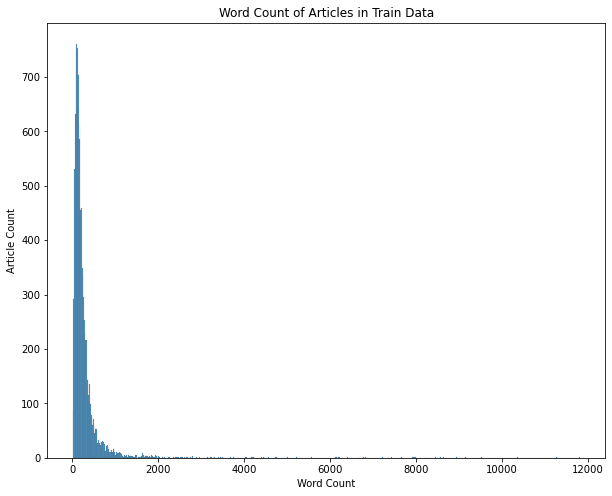

In [7]:
df_train['word_count'] = df_train['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x='word_count')
plt.title('Word Count of Articles in Train Data')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [8]:
train_articles = (sum(df_train['word_count'] < 1000)/df_train.shape[0])*100
print('Percentage of Training Articles having less than 1000 Words:{:.2f}%'.format(train_articles))

Percentage of Training Articles having less than 1000 Words:96.80%


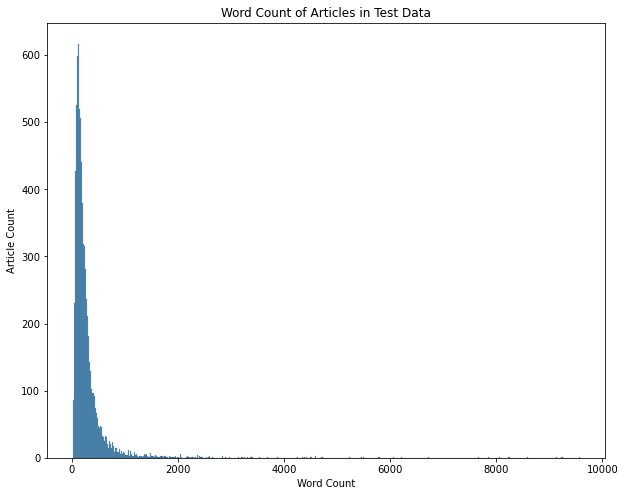

In [9]:
df_test['word_count'] = df_test['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_test, x='word_count')
plt.title('Word Count of Articles in Test Data')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [10]:
test_articles = (sum(df_test['word_count'] < 1000)/df_test.shape[0])*100
print('Percentage of Test Articles having less than 1000 Words:{:.2f}%'.format(test_articles))

Percentage of Test Articles having less than 1000 Words:97.09%


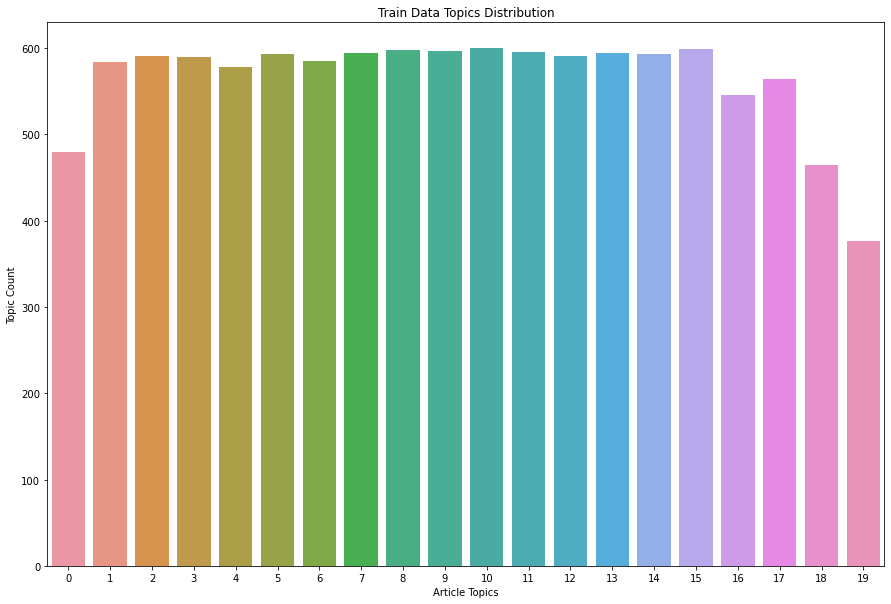

In [11]:
plt.figure(figsize=(15,10))
sns.countplot(data=df_train, x='label')
plt.title('Train Data Topics Distribution')
plt.xlabel('Article Topics')
plt.ylabel('Topic Count')
plt.show()

### Data Cleaning and Pre-processing:\
1. Remove pre and post spaces
2. Lower the case of tweet's text
3. Remove Numbers
4. Remove punctuation and special characters
5. Remove Stopwords
6. Word Lemmatization
7. Preparing feature space vectors

In [12]:
def get_wordnet_pos (tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
def lemmatize (word_list):
    wl = WordNetLemmatizer()
    word_pos_tags = pos_tag(word_list)
    lemmatized_list = []
    for tag in word_pos_tags:
        lemmatize_word = wl.lemmatize(tag[0],get_wordnet_pos(tag[1]))
        lemmatized_list.append(lemmatize_word)
    return " ".join(lemmatized_list)

In [14]:
def clean_text (text):
    # Remove Pre and Post Spaces
    text = str(text).strip()
    
    # Lower case the entire text
    text = str(text).lower()

    # Substitute New Line Characters with spaces 
    text = re.sub(r"\n", r" ", text)
        
    # Tokenize the sentence
    word_tokens = word_tokenize(text)
    
    # Remove the punctuation and  special characters from each individual word
    cleaned_text = []
    for word in word_tokens:
        cleaned_text.append("".join([char for char in word if char.isalnum()]))
    
    # Specify the stop words list
    stop_words = stopwords.words('english')
    
    # Remove the stopwords and words containing less then 2 characters
    text_tokens = [word for word in cleaned_text if (len(word) > 2) and (word not in stop_words)]
    
    #Lemmatize each word in the word list
    text = lemmatize (text_tokens)
    
    return text

In [15]:
df_train['article'][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [16]:
clean_text (df_train['article'][0])

'lerxst wamumdedu thing subject car nntppostinghost rac3wamumdedu organization university maryland college park line wonder anyone could enlighten car saw day 2door sport car look late 60 early 70 call bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car make history whatever info funky look car please email thanks bring neighborhood lerxst'

In [17]:
df_train['article'] = df_train['article'].apply(lambda x: clean_text(x))

In [18]:
df_test['article'] = df_test['article'].apply(lambda x: clean_text(x))

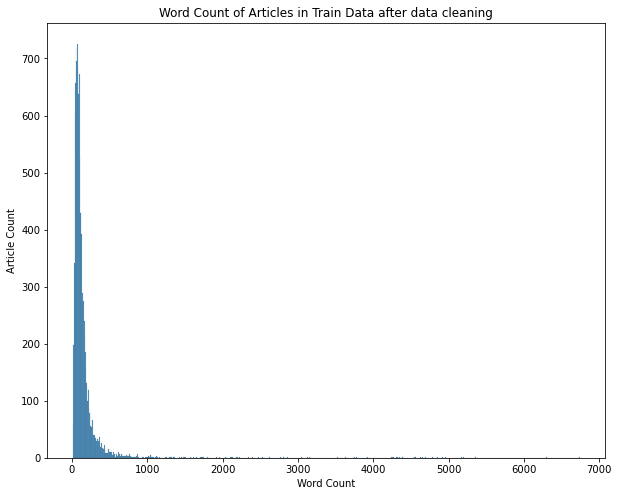

In [19]:
df_train['word_count'] = df_train['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x='word_count')
plt.title('Word Count of Articles in Train Data after data cleaning')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [20]:
train_articles = (sum(df_train['word_count'] < 300)/df_train.shape[0])*100
print('Percentage of Training Articles having less than 300 Words:{:.2f}%'.format(train_articles))

Percentage of Training Articles having less than 300 Words:92.05%


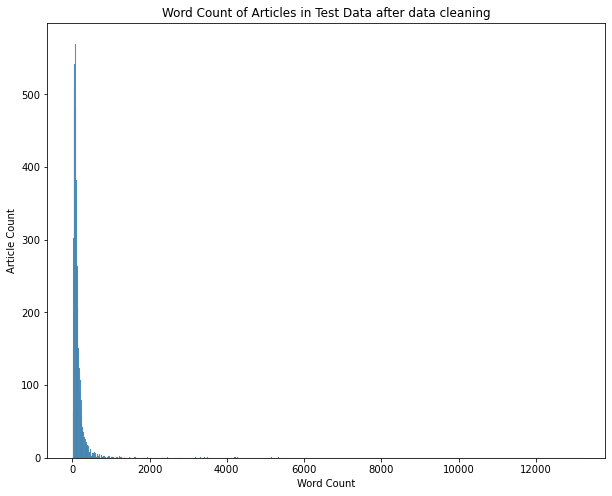

In [21]:
df_test['word_count'] = df_test['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_test, x='word_count')
plt.title('Word Count of Articles in Test Data after data cleaning')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [22]:
test_articles = (sum(df_test['word_count'] < 300)/df_test.shape[0])*100
print('Percentage of Test Articles having less than 300 Words:{:.2f}%'.format(test_articles))

Percentage of Test Articles having less than 300 Words:92.37%


In [23]:
X_train = df_train['article']
y_train = df_train['label']
X_test = df_test['article']
y_test = df_test['label']

In [24]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (11314,)
X_test: (7532,)
y_train: (11314,)
y_test: (7532,)


In [25]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)

In [26]:
vocab_size = len(tokenizer.index_word) + 1
print('Vocab Size:', vocab_size)

Vocab Size: 148442


In [27]:
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [28]:
sequence_len = 1000
X_train_token = pad_sequences(X_train_token, padding='post', maxlen=sequence_len)
X_test_token = pad_sequences(X_test_token, padding='post', maxlen=sequence_len)

### Training Deep Neural Networks using pre-trained GlOve Embeddings

In [29]:
home = os.path.expanduser('~')
glove_embedding_filepath = os.path.join(home, ".torch/datasets/glove_embeddings/glove.6B.100d.txt")

In [30]:
def create_embedding_matrix (filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath) as file:
        for line in file:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix

In [31]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(glove_embedding_filepath, tokenizer.word_index, embedding_dim)

In [32]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_len))
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         14844200  
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                660       
Total params: 14,919,324
Trainable params: 14,919,324
Non-trainable params: 0
____________________________________________

2022-06-14 18:47:46.490552: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-14 18:47:46.491485: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 18:47:46.492909: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [33]:
history = model.fit(X_train_token, y_train, epochs=20, validation_data=(X_test_token, y_test), batch_size=128)

2022-06-14 18:47:46.818230: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-14 18:47:46.842831: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099940000 Hz


Epoch 1/20
89/89 [==============================] - 121s 1s/step - loss: 2.9639 - accuracy: 0.0889 - val_loss: 2.4170 - val_accuracy: 0.3638
Epoch 2/20
89/89 [==============================] - 157s 2s/step - loss: 1.5740 - accuracy: 0.6211 - val_loss: 0.9479 - val_accuracy: 0.7479
Epoch 3/20
89/89 [==============================] - 155s 2s/step - loss: 0.2091 - accuracy: 0.9679 - val_loss: 0.8500 - val_accuracy: 0.7748
Epoch 4/20
89/89 [==============================] - 155s 2s/step - loss: 0.0340 - accuracy: 0.9975 - val_loss: 0.8504 - val_accuracy: 0.7854
Epoch 5/20
89/89 [==============================] - 113s 1s/step - loss: 0.0121 - accuracy: 0.9988 - val_loss: 0.8860 - val_accuracy: 0.7844
Epoch 6/20
89/89 [==============================] - 112s 1s/step - loss: 0.0087 - accuracy: 0.9987 - val_loss: 0.9079 - val_accuracy: 0.7823
Epoch 7/20
89/89 [==============================] - 131s 1s/step - loss: 0.0045 - accuracy: 0.9997 - val_loss: 0.9361 - val_accuracy: 0.7791
Epoch 8/20
89

In [34]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_len, weights = [embedding_matrix], trainable = True))
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         14844200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                660       
Total params: 14,919,324
Trainable params: 14,919,324
Non-trainable params: 0
__________________________________________

In [35]:
history1 = model.fit(X_train_token, y_train, epochs=20, validation_data=(X_test_token, y_test), batch_size=128)

Epoch 1/20
89/89 [==============================] - 107s 1s/step - loss: 2.7900 - accuracy: 0.1694 - val_loss: 1.8443 - val_accuracy: 0.4610
Epoch 2/20
89/89 [==============================] - 104s 1s/step - loss: 1.3861 - accuracy: 0.6176 - val_loss: 1.1903 - val_accuracy: 0.6255
Epoch 3/20
89/89 [==============================] - 104s 1s/step - loss: 0.6819 - accuracy: 0.8225 - val_loss: 0.9858 - val_accuracy: 0.6921
Epoch 4/20
89/89 [==============================] - 106s 1s/step - loss: 0.3248 - accuracy: 0.9283 - val_loss: 0.9196 - val_accuracy: 0.7211
Epoch 5/20
89/89 [==============================] - 105s 1s/step - loss: 0.1487 - accuracy: 0.9772 - val_loss: 0.9108 - val_accuracy: 0.7354
Epoch 6/20
89/89 [==============================] - 105s 1s/step - loss: 0.0624 - accuracy: 0.9962 - val_loss: 0.9093 - val_accuracy: 0.7424
Epoch 7/20
89/89 [==============================] - 107s 1s/step - loss: 0.0291 - accuracy: 0.9987 - val_loss: 0.9389 - val_accuracy: 0.7454
Epoch 8/20
89